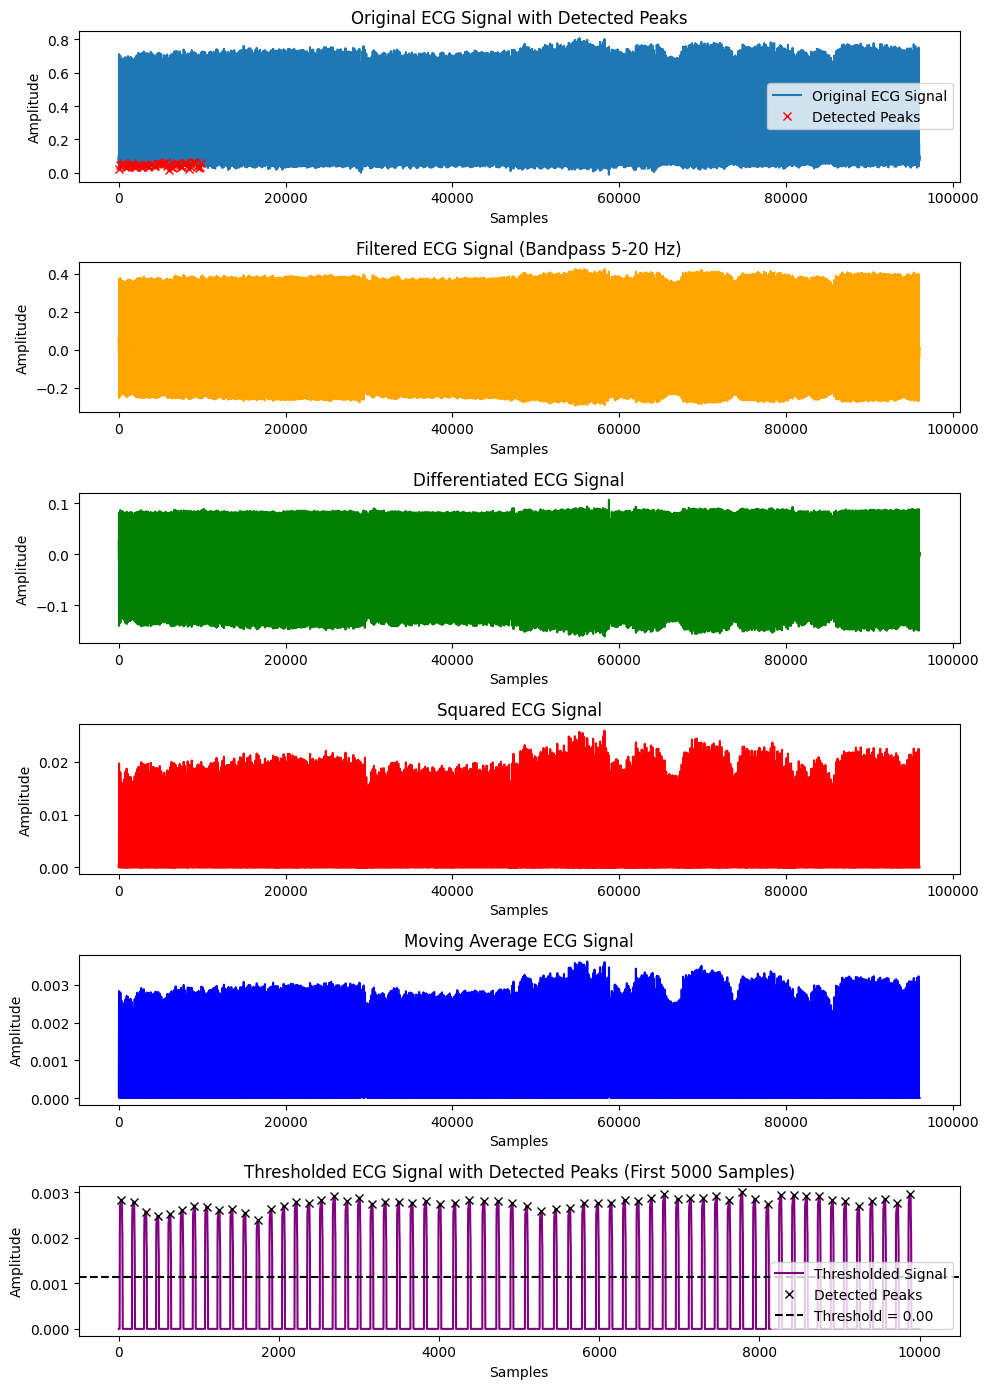

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from scipy import signal
from scipy.signal import find_peaks

# Lowpass and Highpass filter settings
Lowpass_setting = 5  # in Hz
Highpass_setting = 20  # in Hz
window_size = 35  # Window size for moving average
quantile_threshold = 0.5  # Ignore the top 0.5% of the values

# Function to define the bandpass filter
def define_bandpass_filter(lowcut, highcut, fs, order=1):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

# Function to apply a differentiation filter
def apply_differentiation_filter(signal):
    return np.diff(signal, n=1)

# Function to apply a squaring filter
def apply_squaring_filter(signal):
    return np.square(signal)

# Function to apply a moving average filter
def apply_moving_average_filter(signal, window_size):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

# Function to determine the threshold based on a quantile
def determine_threshold(signal, quantile):
    threshold_value = np.quantile(signal, quantile)
    top_values = signal[signal >= threshold_value]
    return np.mean(top_values)

# Function to detect peaks, ensuring no overlapping indices
def detect_peaks(signal, threshold, min_distance):
    peaks, _ = find_peaks(signal, height=threshold, distance=min_distance)
    detected_peaks = []
    
    for peak in peaks:
        if all(abs(peak - p) >= min_distance for p in detected_peaks):  # Check distance from previously detected peaks
            detected_peaks.append(peak)
    
    return np.array(detected_peaks)

# Load the ECG data
record = wfdb.rdrecord(r'C:\Users\baumi\iCloudDrive\Clemson\Computational Modeling\Project 1\CODE\EKG Data\Working Example\196')  # Path to your WFDB file
ecg_matrix = np.array(record.p_signal)
sampling_rate = record.fs

# Apply the bandpass filter
b, a = define_bandpass_filter(Lowpass_setting, Highpass_setting, sampling_rate)
filtered_signal = signal.lfilter(b, a, ecg_matrix[:, 0])  # Filter the first channel

# Apply the differentiation filter
Differentiation_signal = apply_differentiation_filter(filtered_signal)

# Apply the squaring filter
Squared_signal = apply_squaring_filter(Differentiation_signal)

# Apply the moving average filter
Moving_average_signal = apply_moving_average_filter(Squared_signal, window_size)

# Determine the threshold using a quantile-based approach
Threshold = determine_threshold(Moving_average_signal, quantile_threshold)

# Apply the threshold: Set values below the threshold to zero
Thresholded_signal = np.where(Moving_average_signal >= Threshold, Moving_average_signal, 0)

# Adjust the distance parameter (tune this depending on your data)
distance_between_peaks = 50  # Set based on expected QRS complex width

# Index-based Peak detection
detected_peaks = detect_peaks(Thresholded_signal, threshold=Threshold, min_distance=distance_between_peaks)

# Only display the first 5000 values for plotting
Thresholded_signal_5000 = Thresholded_signal[:10000]
detected_peaks_5000 = detected_peaks[detected_peaks < 10000]  # Limit peaks to the first 5000 values

# Plot the results
plt.figure(figsize=(10, 14))

# Original signal with detected peaks
plt.subplot(6, 1, 1)
plt.plot(ecg_matrix[:, 0], label='Original ECG Signal')
plt.plot(detected_peaks_5000, ecg_matrix[detected_peaks_5000, 0], "x", color='red', label='Detected Peaks')
plt.title('Original ECG Signal with Detected Peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

# Filtered signal
plt.subplot(6, 1, 2)
plt.plot(filtered_signal[:], color='orange')
plt.title(f'Filtered ECG Signal (Bandpass {Lowpass_setting}-{Highpass_setting} Hz)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Differentiated signal
plt.subplot(6, 1, 3)
plt.plot(Differentiation_signal[:], color='green')
plt.title('Differentiated ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Squared signal
plt.subplot(6, 1, 4)
plt.plot(Squared_signal[:], color='red')
plt.title('Squared ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Moving average signal
plt.subplot(6, 1, 5)
plt.plot(Moving_average_signal[:], color='blue')
plt.title('Moving Average ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Thresholded signal with detected peaks (limited to first 5000 samples)
plt.subplot(6, 1, 6)
plt.plot(Thresholded_signal_5000, color='purple', label='Thresholded Signal')
plt.plot(detected_peaks_5000, Thresholded_signal_5000[detected_peaks_5000], "x", color='black', label='Detected Peaks')
plt.axhline(y=Threshold, color='black', linestyle='--', label=f'Threshold = {Threshold:.2f}')
plt.title('Thresholded ECG Signal with Detected Peaks (First 5000 Samples)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In the following i define alle functions needed in order to process the signal


In [6]:
# after detecting the peaks, we can calculate the heart rate and the RR interval

# How many beats were detected?

print(f'Number of detected peaks: {len(detected_peaks)}')

# time of recording
time = len(ecg_matrix) / (sampling_rate * 60)
print(f'Time of recording (in minutes): {time}')

# Calculate the RR interval

RR_interval = np.diff(detected_peaks) / sampling_rate  # in seconds
print(f'RR intervals (in seconds): {RR_interval}')

# Calculate the heart rate

Heart_rate = 60 / RR_interval  # in beats per minute
print(f'Heart rate (in bpm): {Heart_rate}')

# Calculate the average heart rate

Average_heart_rate = np.mean(Heart_rate)
print(f'Average heart rate (in bpm): {Average_heart_rate}')

# Calculate the standard deviation of the RR interval

RR_interval_std = np.std(RR_interval)
print(f'Standard deviation of RR intervals (in seconds): {RR_interval_std}')



Number of detected peaks: 527
Time of recording (in minutes): 6.4
RR intervals (in seconds): [0.612 0.604 0.6   0.612 0.608 0.616 0.608 0.624 0.64  0.644 0.668 0.64
 0.632 0.624 0.632 0.632 0.644 0.628 0.62  0.636 0.656 0.668 0.672 0.68
 0.716 0.74  0.732 0.72  0.704 0.708 0.724 0.736 0.708 0.708 0.696 0.696
 0.672 0.676 0.676 0.664 0.652 0.652 0.648 0.648 0.644 0.64  0.632 0.644
 0.648 0.648 0.648 0.64  0.644 0.652 0.652 0.66  0.652 0.652 0.636 0.628
 0.628 0.636 0.644 0.664 0.672 0.664 0.664 0.688 0.704 0.704 0.7   0.684
 0.712 0.716 0.704 0.712 0.716 0.728 0.708 0.7   0.684 0.704 0.716 0.724
 0.7   0.692 0.708 0.748 0.948 0.82  0.788 0.76  0.772 0.784 0.776 0.768
 0.776 0.792 0.804 0.788 0.78  0.792 0.768 0.752 0.744 0.74  0.884 0.84
 0.748 0.72  0.732 0.704 0.668 0.656 0.672 0.692 0.72  0.732 0.748 0.752
 0.76  0.772 0.756 0.752 0.772 0.772 0.768 0.764 0.76  0.74  0.732 0.736
 0.752 0.736 0.732 0.72  0.76  0.804 0.78  0.768 0.78  0.776 0.904 0.84
 0.792 0.788 0.784 0.76  0.76  0.76